# Traffic Sign Recognition

## Dataset loading and exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import tensorflow as tf
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import math
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from keras.optimizers import SGD
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Load our dataset

In [ ]:
# Show plots inline notebook
%matplotlib inline

# Location of the dataset

training_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/train.p'
validation_file='/content/drive/MyDrive/Colab Notebooks/Datasets/valid.p'
testing_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/test.p'


# Open the files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Save the features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Unique classes/labels in the dataset
n_classes = len(np.unique(y_train))

# Make one hot targets
y_train_hot = to_categorical(y_train, num_classes=n_classes)
y_valid_hot = to_categorical(y_valid, num_classes=n_classes)
y_test_hot = to_categorical(y_test, num_classes=n_classes)

print("Traffic Sign Dataset loaded!")

Traffic Sign Dataset loaded!


Basic Summary of the Data Set Using Numpy

In [ ]:
# Number of training examples
n_train = len(y_train)
# Number of validation examples.
n_valid = len(y_valid)
# Number of testing examples.
n_test = len(y_test)

# Shape of a traffic sign image
image_shape = np.shape(X_train[0])

# Print out the results
print("Number of training examples = {}".format(n_train))
print ("Number of validation examples = {}".format(n_valid))
print ("Percentage of validation examples: {:2.2f}%".format((n_valid/(n_train*1.0))*100))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(X_train[0].shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 34799
Number of validation examples = 4410
Percentage of validation examples: 12.67%
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Print out a table with sign names, class ID and counts for better identification

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/signnames.csv')
_, class_counts = np.unique(y_train, return_counts = True)
data_pd['Counts'] = class_counts
print(data_pd)

    ClassId                                           SignName  Counts
0         0                               Speed limit (20km/h)     180
1         1                               Speed limit (30km/h)    1980
2         2                               Speed limit (50km/h)    2010
3         3                               Speed limit (60km/h)    1260
4         4                               Speed limit (70km/h)    1770
5         5                               Speed limit (80km/h)    1650
6         6                        End of speed limit (80km/h)     360
7         7                              Speed limit (100km/h)    1290
8         8                              Speed limit (120km/h)    1260
9         9                                         No passing    1320
10       10       No passing for vehicles over 3.5 metric tons    1800
11       11              Right-of-way at the next intersection    1170
12       12                                      Priority road    1890
13    

Display 100 random traffic signs, together with their label below

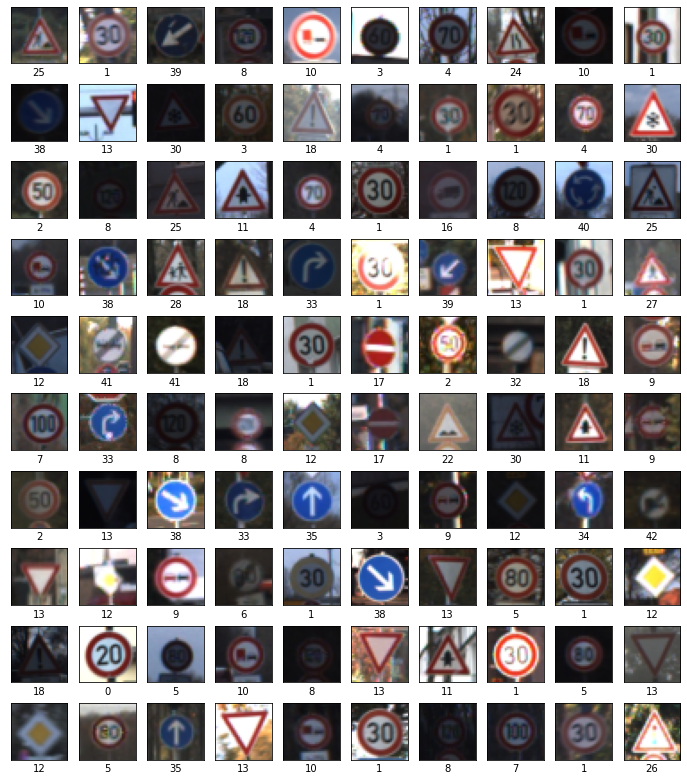

In [ ]:
def showRandomImages(gray = False):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, 100):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(10,10,i+1)
        axis.set_xlabel(y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if not gray:
            axis.imshow(X_train[number])
        else:
            axis.imshow(X_train[number], cmap='gray')
    plt.show()

showRandomImages()

Show a distribution of the training and testing data in the set, counts per class over class ID

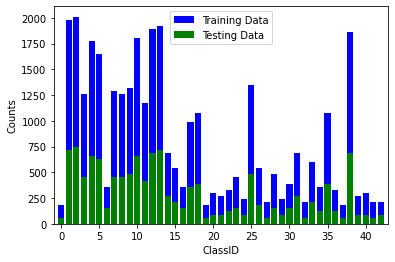

In [ ]:
def showDistribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 43 ), training_counts, align='center',  color='b', label='Training Data')
    plt.bar( np.arange( 43 ), test_counts, align='center', color='g', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([-1, 43])
    plt.legend()
    plt.show()
    
showDistribution()

Convert images to grayscale, as color information is not really required

In [ ]:
def convertToGray(image_data):
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
    image_data = np.reshape(image_data, (32, 32, 1))
    return image_data

X_train = np.array([convertToGray(X_train[i]) for i in range(len(X_train))])
X_valid = np.array([convertToGray(X_valid[i]) for i in range(len(X_valid))])
X_test = np.array([convertToGray(X_test[i]) for i in range(len(X_test))])
print("Images converted to grayscale!")

Images converted to grayscale!


Calculate the weight influence compared to the majority class

In [ ]:
def get_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    majority = max(counts)
    return  {cls: float(majority/count) for cls, count in zip(unique, counts)}

class_weights = get_class_weights(y_train)
print(class_weights)

{0: 11.166666666666666, 1: 1.0151515151515151, 2: 1.0, 3: 1.5952380952380953, 4: 1.1355932203389831, 5: 1.2181818181818183, 6: 5.583333333333333, 7: 1.558139534883721, 8: 1.5952380952380953, 9: 1.5227272727272727, 10: 1.1166666666666667, 11: 1.7179487179487178, 12: 1.0634920634920635, 13: 1.046875, 14: 2.9130434782608696, 15: 3.7222222222222223, 16: 5.583333333333333, 17: 2.0303030303030303, 18: 1.8611111111111112, 19: 11.166666666666666, 20: 6.7, 21: 7.444444444444445, 22: 6.090909090909091, 23: 4.466666666666667, 24: 8.375, 25: 1.488888888888889, 26: 3.7222222222222223, 27: 9.571428571428571, 28: 4.1875, 29: 8.375, 30: 5.153846153846154, 31: 2.9130434782608696, 32: 9.571428571428571, 33: 3.35559265442404, 34: 5.583333333333333, 35: 1.8611111111111112, 36: 6.090909090909091, 37: 11.166666666666666, 38: 1.0806451612903225, 39: 7.444444444444445, 40: 6.7, 41: 9.571428571428571, 42: 9.571428571428571}


## Model Architecture

Do some data augmentation by changing brightness, rotation, translation and transformation

In [ ]:
# Data generator for image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False, 
    featurewise_std_normalization=False, 
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

Define our model in Keras and show an overview

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

def VGG16():
    custom_vgg = Sequential()
    custom_vgg.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = "relu", input_shape = (32, 32, 1)))
    # custom_vgg.add(Dropout(0.2))
    custom_vgg.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = "relu"))
    custom_vgg.add(Dropout(0.2))
    custom_vgg.add(MaxPooling2D((2, 2)))

    custom_vgg.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu"))
    # custom_vgg.add(Dropout(0.2))
    custom_vgg.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu"))
    custom_vgg.add(Dropout(0.2))
    custom_vgg.add(MaxPooling2D((2, 2)))

    custom_vgg.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu"))
    # custom_vgg.add(Dropout(0.2))
    custom_vgg.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu"))
    custom_vgg.add(Dropout(0.2))
    custom_vgg.add(MaxPooling2D((2, 2)))

    custom_vgg.add(Flatten())
    custom_vgg.add(Dense(43, activation = "softmax"))

    return custom_vgg
    

model = VGG16()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 32, 32, 32)        0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 16, 16, 64)        0

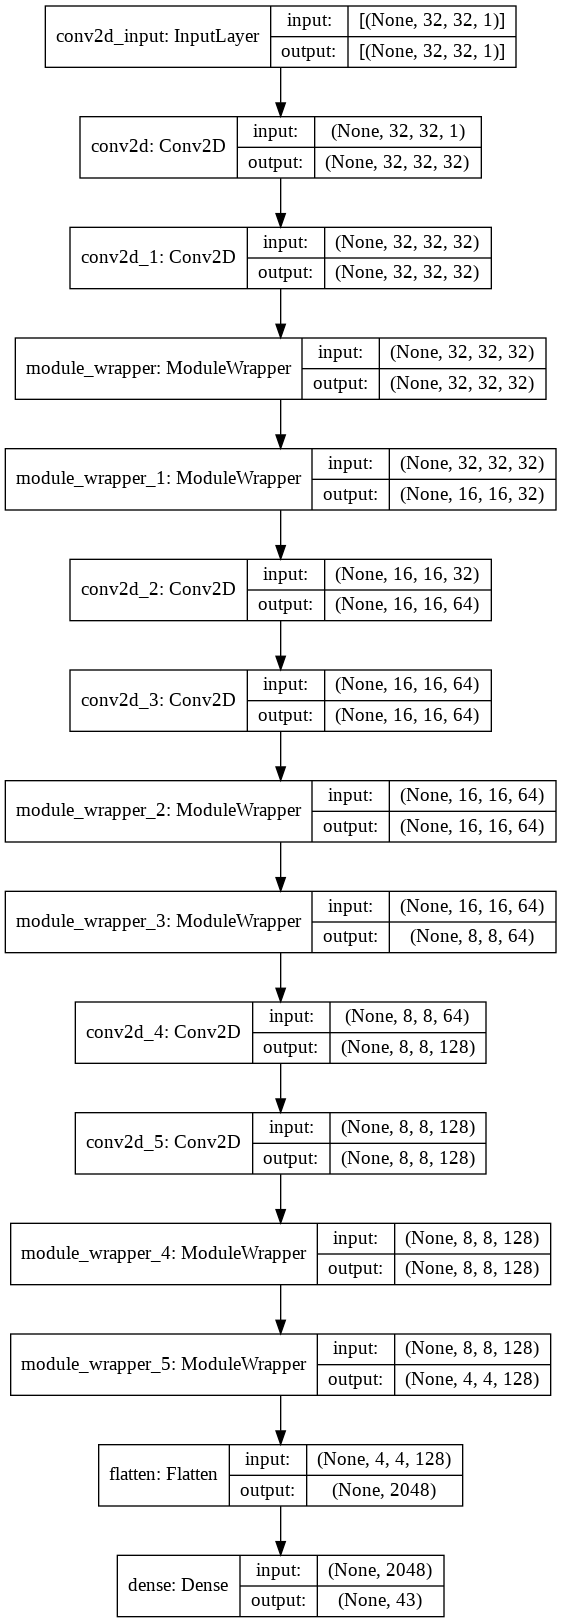

In [ ]:
tf.keras.utils.plot_model(model,
                              to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,)
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.utils.vis_utils import plot_model
# tf.keras.utils.plot_model(model, to_file='model_combined.png')

## Train, Validate and Test the Model

Train our model for 100 epochs maximum

In [ ]:
# Our training data generator
train_generator = train_datagen.flow(X_train, y_train_hot, batch_size=128)

# Out validation data generator
validation_generator = test_datagen.flow(X_valid, y_valid_hot, batch_size=128)

In [ ]:
# Let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Early stopping, if progress on validation data does not improve after 10 epochs
# early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')

# Our learning rate scheduler
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

# Train our model
history = model.fit_generator(train_generator, steps_per_epoch=len(X_train) / 128, epochs=45,
        validation_data=validation_generator, validation_steps=len(X_valid) / 128, 
        class_weight=class_weights, verbose=2)

# Save the model to file
# Print message
print("Model trained!")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/45


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


271/271 - 13s - loss: 6.9992 - accuracy: 0.2268 - val_loss: 1.4225 - val_accuracy: 0.5893
Epoch 2/45
271/271 - 10s - loss: 2.1105 - accuracy: 0.7119 - val_loss: 0.6909 - val_accuracy: 0.7859
Epoch 3/45
271/271 - 10s - loss: 0.9042 - accuracy: 0.8707 - val_loss: 0.3522 - val_accuracy: 0.9005
Epoch 4/45
271/271 - 10s - loss: 0.5096 - accuracy: 0.9186 - val_loss: 0.2501 - val_accuracy: 0.9354
Epoch 5/45
271/271 - 9s - loss: 0.3512 - accuracy: 0.9450 - val_loss: 0.2086 - val_accuracy: 0.9526
Epoch 6/45
271/271 - 9s - loss: 0.2943 - accuracy: 0.9536 - val_loss: 0.2265 - val_accuracy: 0.9435
Epoch 7/45
271/271 - 9s - loss: 0.2328 - accuracy: 0.9632 - val_loss: 0.1896 - val_accuracy: 0.9558
Epoch 8/45
271/271 - 9s - loss: 0.1656 - accuracy: 0.9722 - val_loss: 0.1290 - val_accuracy: 0.9703
Epoch 9/45
271/271 - 9s - loss: 0.1729 - accuracy: 0.9740 - val_loss: 0.1563 - val_accuracy: 0.9540
Epoch 10/45
271/271 - 9s - loss: 0.1573 - accuracy: 0.9746 - val_loss: 0.1112 - val_accuracy: 0.9599
Epoch 

In [ ]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/Datasets/model.h5')


Show loss and accuracy for training and validation data

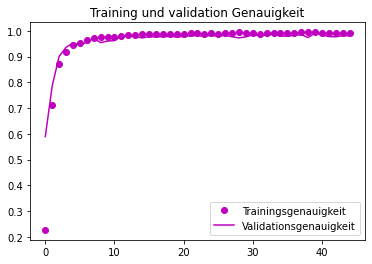

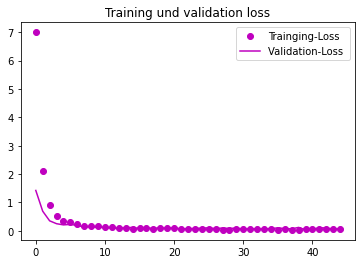

In [ ]:
#plot accuracy for modle0
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'mo', label="Trainingsgenauigkeit")
plt.plot(epochs, val_acc, 'm', label="Validationsgenauigkeit")
plt.title('Training und validation Genauigkeit')
plt.legend(loc="lower right")
plt.figure()
plt.plot(epochs, loss, 'mo', label="Trainging-Loss ")
plt.plot(epochs, val_loss, 'm', label="Validation-Loss ")
plt.title('Training und validation loss')
plt.legend(loc="upper right")
plt.show()

Evaluate the model on the test data

In [ ]:
# Out validation data generator
test_generator = test_datagen.flow(X_test, y_test_hot, batch_size=128)

# Calculate score
score = model.evaluate_generator(test_generator, len(X_test) / 128)
print("Test loss is: " + str(score[0]))
print("Test accuracy is: " + str(score[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss is: 0.11968385428190231
Test accuracy is: 0.972050666809082


##cofusion matrix
build confusion matrix 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

val_gen_no_shuffle = test_datagen.flow(X_test, y_test,batch_size=128,shuffle=False)

# Use the model to predict (will take a couple of minutes)
predictions_balanced = model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred_balanced)}")

Accuracy Score: 0.9720506730007917
Balanced Accuracy Score: 0.9603050436998871


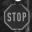

In [ ]:
from google.colab.patches import cv2_imshow

X_test[456].shape
cv2_imshow(X_test[456])

In [ ]:
data = model.predict(X_test)
x = np.argmax(data, axis=1)

In [ ]:
x.shape

(12630,)

In [ ]:
x[456]

14

In [ ]:
y_test[456] 

14

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

balanced_cm = confusion_matrix(y_test, y_pred_balanced)

In [ ]:
balanced_cm.shape

(43, 43)

In [ ]:
balanced_cm[2]

array([  0,   1, 745,   2,   1,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

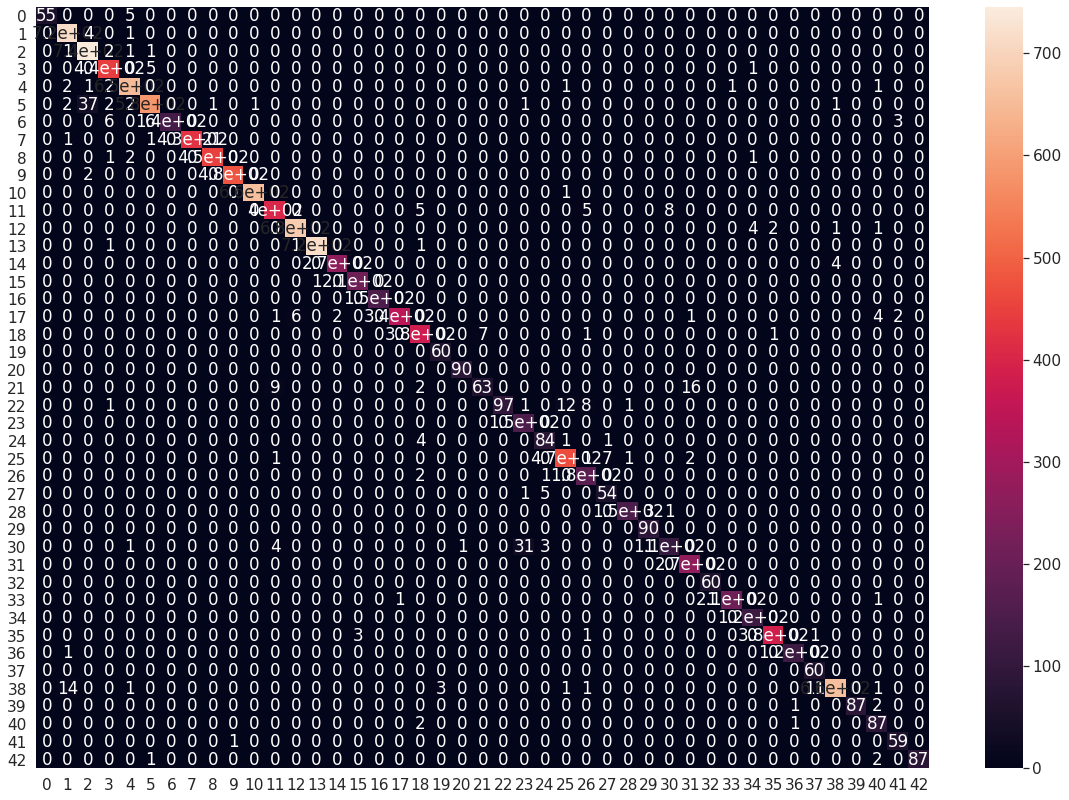

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))

sn.set(font_scale=1.4) # for label size
# sn.heatmap(balanced_cm) # font size
sn.heatmap(balanced_cm, annot=True) # font size

plt.show()

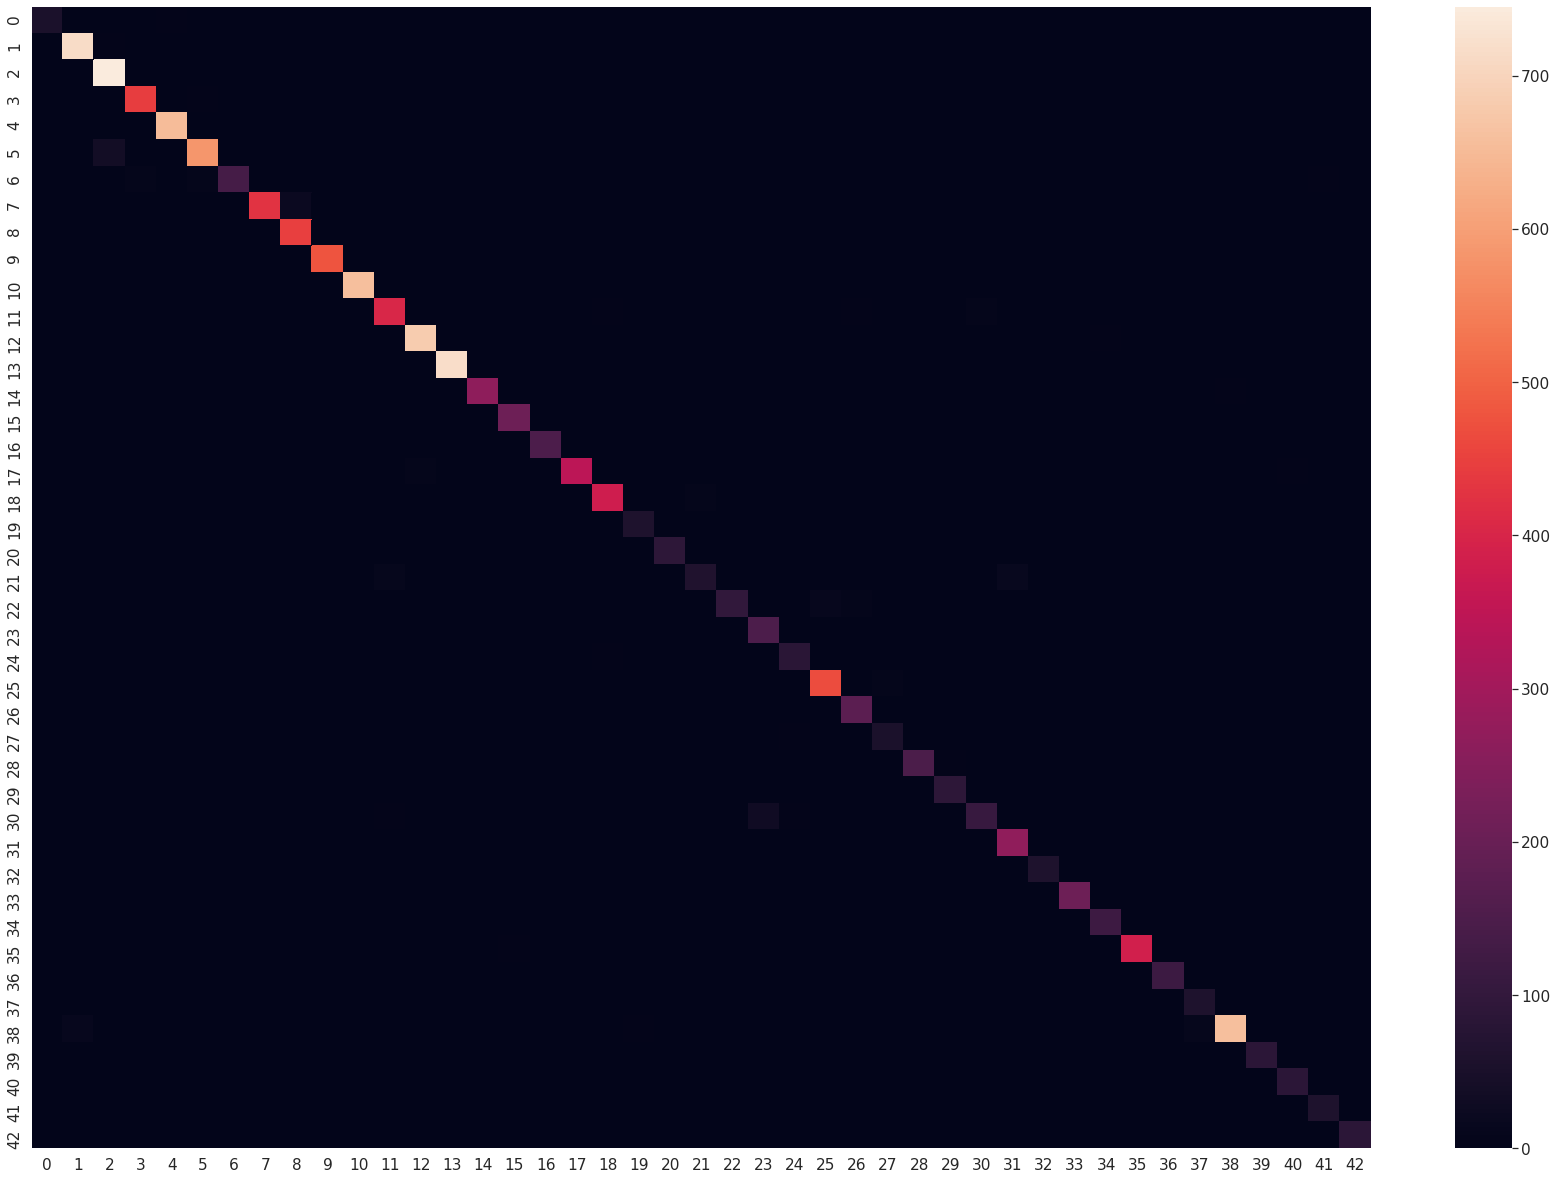

In [ ]:
plt.figure(figsize=(30,21))

sn.set(font_scale=1.4) # for label size
sn.heatmap(balanced_cm) # font size
plt.show()


## Test model on new images

Load the network

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Datasets/model.h5')
print("Network loaded!")

ValueError: ignored

Show the images we want to use for our test

In [ ]:
# Name of the five test images
imageNames = ['S1.jpg', 'S2.jpg', 'S3.jpg', 'S4.jpg', 'S5.jpg', 'S6.jpg', 'S7.jpg', 'S8.jpg', 'S9.jpg', 'S10.jpg']

def showTestImages(labels = None):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, len(imageNames)):
        axis = fig.add_subplot(10,10,i+1)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        
        # Show labels if provided
        if labels is not None:
            axis.set_xlabel(labels[i])
        # Load image from file
        img = mpimg.imread('test_images/' + imageNames[i])
        # Show it
        axis.imshow(img)

    # Show the plot
    plt.show()

showTestImages()

Store the image pixels and convert the image to grayscale

In [ ]:
# Store the image pixels here
images = []
for i in range(0, len(imageNames)):
    img = mpimg.imread('test_images/' + imageNames[i])
    images.append(img)
    
# Store the true classes here
true_classes = np.array([12, 38, 18, 28, 4, 13, 18, 23, 14, 4])

# Convert the new images to grayscale
images = np.array([convertToGray(images[i]) for i in range(len(images))])

# Normalize
images = (images / 255.0).astype(np.float32)

print("Images converted to grayscale and normalized!")

Predict the sign type for each image and the probabilities

In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# Predict classes and probabilities
predicted_classes = model.predict_classes(images, verbose=0)
prob_classes = model.predict(images, verbose=0)
print("Prediction finished!")
    
# Print out accuracy
test_accuracy = (np.sum(predicted_classes == true_classes) / len(true_classes)) * 100.0
print("Test Accuracy: {:2.2f}%".format(test_accuracy))

Show the test images with their predicted labels

In [ ]:
showTestImages(predicted_classes)

Compare what the real classes are

In [ ]:
for i in range(0,len(imageNames)):
    print("Image {} - Predicted class =  {}, true class = {}".format(i+1, predicted_classes[i], true_classes[i]))

Show the estimated classes distribution for each image

In [ ]:
figure = plt.figure(figsize=(10,15))
for i in range(0,len(imageNames)):
    axis = figure.add_subplot(len(imageNames),1,i+1)
    axis.set_xlabel("Classes")
    axis.set_ylabel("Prob")
    axis.set_title("Image {}".format(i+1) , fontsize=16)
    plt.xticks(range(0,43))
    axis.plot(range(0,43),prob_classes[i])

plt.tight_layout(h_pad=3, w_pad=0)    

You can see that the network was able to classify 9 of 10 test images correctly. It failed for the last one, because it is a traffic sign from a non-german country, and the network was only trained was german signs. But in the distribution of the last sign, the network was pretty unsure what to do, with the maximum probability at around 0.2.